In [75]:
import warnings
warnings.filterwarnings('ignore')

import gzip
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time

from decimal import Decimal
from matplotlib import gridspec
from os import walk
from scipy import stats

# import motif algorithm functions
sys.path.append("../../utils")
from utils import *

%matplotlib inline
mpl.rcParams['figure.dpi'] = 90

In [76]:
# seaborn graphics pre-sets

# for notebook
# sns.set(style="white", font="Arial", font_scale=1.2, context="notebook")
# fontsize = 10

# for paper
sns.set(style="ticks", font="Helvetica", context="paper", rc={"font.size":7,"axes.titlesize":7,
                                                              "axes.labelsize":7, 'axes.linewidth':0.5,
                                                              "legend.fontsize":6, "xtick.labelsize":6,
                                                              "ytick.labelsize":6, "xtick.major.size": 3.0,
                                                              "ytick.major.size": 3.0, "axes.edgecolor": "black",
                                                              "xtick.major.pad": 3.0, "ytick.major.pad": 3.0})
fontsize = 7

In [77]:
COLOR_DICT = {"A": "crimson", "C": "mediumblue", "G": "orange", "T": "forestgreen"}

## functions

In [78]:
def get_del_num(row):
    if "DELETION" in row.unique_id:
        #print(row.unique_id)
        old_name = row["unique_id"]
        del_num = int(old_name.split("__")[4].split(".")[4])
    else:
        del_num = 0
    return del_num

In [79]:
def get_del_base(row, seq_map):
    if "DELETION" in row.unique_id:
        seq = seq_map[row.element]
        base = seq[row.delpos-1]
    else:
        base = "X"
    return base

In [80]:
def fix_dupe_info(row):
    """
    this function is only necessary because i did the dupe_info column stupidly in this index.
    need to put in format where the dupe_info always contains one value (its tile_id), 
    and if there is a dupe, a comma-separated list of them.
    """
    new_oligo_id = ".".join(row.oligo_id.split(".")[:-1])
    if row.dupe_info == "none":
        return new_oligo_id
    else:
        return "%s,%s" % (new_oligo_id, row.dupe_info)

In [81]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [82]:
def fix_del_num(row):
    try:
        dupe_num = int(row.dupe_info.split(".")[-2])
        if row.delpos == dupe_num:
            return row.delpos
        else:
            return dupe_num
    except:
        return row.delpos

In [83]:
def scale_range(data, minTo, maxTo):
    """
    function to scale data linearly to a new min/max value set
    
    parameters
    ----------
    data: array like, list of numbers
    minTo: float, minimum of new range desired
    maxTo: float, maximum of new range desired
    
    returns
    -------
    scaled_data: array like, new list of numbers (appropriately scaled)
    """
    minFrom = np.min(data)
    maxFrom = np.max(data)
    
    scaled_data = []
    
    for point in data:
        new_point = minTo + (maxTo - minTo) * ((point - minFrom)/(maxFrom - minFrom))
        scaled_data.append(new_point)
    
    return scaled_data

In [84]:
def calculate_tissue_specificity(df):
    array = df.as_matrix()
    array_max = np.max(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    specificities = np.sum(tmp, axis=1)/(array.shape[1])
    return specificities

In [85]:
def scale_range(data, minTo, maxTo):
    """
    function to scale data linearly to a new min/max value set
    
    parameters
    ----------
    data: array like, list of numbers
    minTo: float, minimum of new range desired
    maxTo: float, maximum of new range desired
    
    returns
    -------
    scaled_data: array like, new list of numbers (appropriately scaled)
    """
    minFrom = np.nanmin(data)
    maxFrom = np.nanmax(data)
    
    scaled_data = []
    
    for point in data:
        new_point = minTo + (maxTo - minTo) * ((point - minFrom)/(maxFrom - minFrom))
        scaled_data.append(new_point)
    
    return scaled_data

### variables

In [157]:
cell_type = "HepG2"

In [158]:
tfbs_f = "../../misc/5__fimo/pool2.noRandom.noScrambled.seqID.nMotifs.txt"

In [159]:
del_dir = "../../data/4__deletions/%s" % cell_type

In [160]:
map_file = "../../data/4__deletions/%s_filename_map.txt" % cell_type
index_file = "../../data/0__index/twist_reorder_pool2_v19_seqID.txt"
header_file = "../../data/0__index/Twist_Pools_Header.txt"

In [161]:
name_dict = {"CDKN2B-AS": "ANRIL", "ZNFX1-AS1": "ZFAS1", "FLJ43663": "LINC_PINT", "LOC400550": "FENDRR", 
             "ENST00000416894": "FALEC", "ENST00000483525": "SAMMSON", "ENST00000513626": "LUCAT1"}
loc_dict = {"chr16:86543137..86543345": "FOXF1", "chr20:47893097..47893305": "enhancer_ZFAS1", 
            "chr3:169482079..169482287": "enhancer_TERC", "chr7:130796089..130796297": "enhancer_LINC_PINT", 
            "chr11:65187510..65187718": "enhancer_NEAT1", "chr11:65265021..65265229": "enhancer_MALAT1"}

In [162]:
cov_f = "../../misc/7__motif_clusters/%s__algorithm_coverage.txt" % cell_type

In [163]:
hepg2_activ_f = "../../data/2__activities/POOL2__pMPRA1__HepG2__activities_per_element.txt"
hela_activ_f = "../../data/2__activities/POOL2__pMPRA1__HeLa__activities_per_element.txt"
k562_activ_f = "../../data/2__activities/POOL2__pMPRA1__K562__activities_per_element.txt"

In [164]:
cluster_f = "../../misc/7__motif_clusters/cluster_map.txt"
fimo_f = "../../misc/5__fimo/pool2.fimo.txt"

## 1. import data

In [165]:
tfbs = pd.read_table(tfbs_f, sep="\t", header=None)
tfbs.columns = ["unique_id", "n_tfs"]
tfbs.head()

,unique_id,n_tfs
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,16
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,10
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,14
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,16
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,16


In [166]:
len(tfbs)

4229

In [167]:
index = pd.read_table(index_file, sep="\t", header=None)
header = pd.read_table(header_file, sep="\t", header=None)
header_list = list(header[0])
index.columns = header_list
index.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,tile_number,local_start,local_end,RE_count_1,RE_count_2,RE_count_3,SNP,barcode,element,unique_id
0,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,GATTCGTCGTG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
1,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.2,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CGAGATAAGTT,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
2,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.3,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CTCGATTAAGG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
3,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.4,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,TGAATAAGTCA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
4,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.5,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CCTAATCGACA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...


In [168]:
files = []
for (dirpath, dirnames, filenames) in walk(del_dir):
    files.extend(filenames)
    break
files = [x for x in files if "loss_score_data" in x]

In [169]:
dels = {}
for f in files:
    name = "%s__%s__%s__%s" % (f.split("__")[0], f.split("__")[1], f.split("__")[2], f.split("__")[3])
    print(name)
    df = pd.read_table("%s/%s" % (del_dir, f))
    dels[name] = df

CRNDE__p1__tile1__plus
CRNDE__p1__tile2__plus
ANRIL__p1__tile1__minus
ZFAS1__p1__tile2__plus
ZFAS1__p1__tile1__plus
enhancer_LINC_PINT__pX__tile1__minus
CDKN2A__p1__tile1__minus
PVT1__p1__tile2__plus
CDKN2A__p1__tile1__plus
GAS5__p1__tile1__minus
GAS5__p1__tile2__minus
HOTAIR__p1__tile2__minus
MALAT1__p1__tile2__plus
DLEU1__p1__tile2__plus
DLEU1__p1__tile1__plus
ANRIL__p1__tile2__minus
CDKN2A__p1__tile2__plus
MEG3__p1__tile2__plus
PVT1__p1__tile1__plus
SAMMSON__p1__tile2__plus
enhancer_MALAT1__pX__tile1__minus
enhancer_MALAT1__pX__tile2__minus
LINC00467__p1__tile1__plus
LINC00467__p1__tile2__plus
CDKN2A__p1__tile2__minus
LINC_PINT__p2__tile2__minus
NEAT1__p1__tile2__plus
LUCAT1__p1__tile2__minus
ANRIL__p1__tile2__plus
FENDRR__p1__tile1__plus
enhancer_NEAT1__pX__tile2__minus
TERC__p1__tile2__minus
JPX__p1__tile2__plus
FENDRR__p1__tile2__minus
JPX__p1__tile1__plus
LINC_PINT__p2__tile1__minus
FOXF1__p__tile1__plus
MALAT1__p4__tile1__plus
MALAT1__p4__tile2__plus
FOXF1__p__tile2__plus
IRX5_

In [170]:
dels["ZFAS1__p1__tile2__plus"].head()

,delpos,mean.log2FC,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end,scaled_score,loss_score_raw,loss_score_raw_scaled,filtered_score,sd,peak
0,11,0.063207,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,0.299069,0.000000,0.000000,NaN,0.090565,no peak
1,12,0.063207,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,0.299069,0.000000,0.000000,NaN,0.090565,no peak
2,13,-0.110958,0.025450,C,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,-0.525009,0.110958,0.045522,0.009575,0.098566,no peak
3,14,-0.002866,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,-0.013562,0.002866,0.001176,0.009810,0.048376,no peak
4,15,-0.002866,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,-0.013562,0.002866,0.001176,0.009810,0.048376,no peak


In [171]:
cov = pd.read_table(cov_f, sep="\t")
cov.head()

,del_id,n_bp_covered,max_coverage,avg_tf_tissue_sp
0,LINC00467__p1__tile2__plus,74,12,0.374063
1,HOTAIR__p1__tile2__minus,39,33,0.416435
2,CRNDE__p1__tile1__minus,14,0,NaN
3,MALAT1__p4__tile2__plus,46,10,0.336289
4,TERC__p1__tile1__minus,41,36,0.417745


In [172]:
clusters = pd.read_table(cluster_f, sep="\t")
clusters.head()

,motif,cluster_num,cluster_count
0,ALX3,55,50
1,ARNT::HIF1A,115,2
2,ATF4,75,3
3,ATF7,106,2
4,Ahr::Arnt,4,4


In [173]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo.columns = ["motif", "unique_id", "start", "stop", "strand", "score", "pval", "qval", "seq"]
fimo.head()

,motif,unique_id,start,stop,strand,score,pval,qval,seq
0,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,39,59,-,27.0204,4.070000e-11,0.000024,GGAGGAGGGAGGGGAGGGGAG
1,ZNF263,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@IRX5__c...,24,44,+,26.6735,6.730000e-11,0.000024,GGAGGAGGAAGAGGGAGAGGG
2,RREB1,WILDTYPE_BUT_HAS_SNP_DELETION__mrna.flip.sense...,24,43,-,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
3,RREB1,FLIPPED_DELETION__mrna.flip.antisense__p1@CDKN...,71,90,+,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
4,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,38,58,-,25.3878,3.590000e-10,0.000024,GAGGGAGGGAGGGGAGGGGGG


## 2. parse snp & del ids so they match

In [174]:
def fix_names(row, name_dict, loc_dict):
    old_name = row["unique_id"]
    #print(old_name)
    chrom = old_name.split("__")[3].split(":")[0]
    start = int(old_name.split("__")[3].split(":")[1].split("..")[0])
    end = int(old_name.split("__")[3].split(":")[1].split("..")[1].split(",")[0])
    strand = old_name.split("__")[3].split(",")[1]
    locs = "%s:%s-%s" % (chrom, start, end)
    if strand == "+":
        text_strand = "plus"
    else:
        text_strand = "minus"
    tile_num = int(old_name.split("__")[4].split(".")[1])
    
    name = old_name.split("__")[2]
    coords = old_name.split("__")[3].split(",")[0]
    try:
        gene = name.split(",")[0].split("@")[1]
        prom = name.split(",")[0].split("@")[0]
    except:
        gene = "X"
        prom = "pX"
    
    if gene not in name_dict.keys() and coords not in loc_dict.keys():
        name = "%s__%s__tile%s" % (gene, prom, tile_num)
    elif gene in name_dict.keys():
        name = "%s__%s__tile%s" % (name_dict[gene], prom, tile_num)
    elif coords in loc_dict.keys():
        name = "%s__%s__tile%s" % (loc_dict[coords], prom, tile_num)
    
    clean_name = "%s__%s" % (name, text_strand)
    return clean_name

In [175]:
tfbs["del_id"] = tfbs.apply(fix_names, name_dict=name_dict, loc_dict=loc_dict, axis=1)
tfbs["delpos"] = tfbs.apply(get_del_num, axis=1)
tfbs.sample(5)

,unique_id,n_tfs,del_id,delpos
1848,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.flip.se...,30,FENDRR__p1__tile1__minus,39
4105,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,35,enhancer_MALAT1__pX__tile1__minus,0
2376,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,5,LUCAT1__p1__tile2__minus,34
1553,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,13,enhancer_ZFAS1__pX__tile2__minus,75
3604,WILDTYPE_BUT_HAS_SNP_DELETION__mrna.noflip.NA_...,20,FOXF1__p__tile1__plus,70


In [176]:
tfbs_wt = tfbs[(~tfbs["unique_id"].str.contains("DELETION")) & 
               (~tfbs["unique_id"].str.contains("SNP_INDIV")) & 
               (~tfbs["unique_id"].str.contains("HAPLO"))]
tfbs_wt.sample(5)

,unique_id,n_tfs,del_id,delpos
521,FLIPPED__Lincrna.flip.antisense__p1@LOC400550_...,29,FENDRR__p1__tile2__plus,0
3700,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@DL...,46,DLEU1__p1__tile1__plus,0
3693,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr2...,13,enhancer_ZFAS1__pX__tile2__minus,0
522,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,22,CDKN2A__p1__tile1__plus,0
532,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,7,MEG3__p1__tile1__plus,0


## 3. add required info to deletion df

In [177]:
# first create a dict of del seq : wt seq map
index_dels = index[index["oligo_type"].str.contains("DELETION")][["oligo_type", "tile_name", "element"]].drop_duplicates()
print("mapping %s unique deletion sequences" % (len(index_dels)))
index_wt = index[index["oligo_type"] == "WILDTYPE"][["oligo_type", "tile_name", "element"]].drop_duplicates()
index_wt_w_snp = index[index["oligo_type"] == "WILDTYPE_BUT_HAS_SNP"][["oligo_type", "tile_name", "element"]].drop_duplicates()
index_fl = index[index["oligo_type"] == "FLIPPED"][["oligo_type", "tile_name", "element"]].drop_duplicates()
dels_dict = {}
for i, row in index_dels.iterrows():
    if "WILDTYPE_BUT_HAS_SNP" in row.oligo_type:
        seq = index_wt_w_snp[index_wt_w_snp["tile_name"] == row.tile_name]["element"].iloc[0]
    elif "WILDTYPE" in row.oligo_type:
        seq = index_wt[index_wt["tile_name"] == row.tile_name]["element"].iloc[0]
    elif "FLIPPED" in row.oligo_type:
        seq = index_fl[index_fl["tile_name"] == row.tile_name]["element"].iloc[0]
    dels_dict[row.element] = seq

mapping 3964 unique deletion sequences


In [178]:
# add deletion number to index
print("finding deletion numbers...")
index["delpos"] = index.apply(get_del_num, axis=1)

finding deletion numbers...


In [179]:
print("finding deletion bases...")
index["del_base"] = index.apply(get_del_base, seq_map=dels_dict, axis=1)

finding deletion bases...


In [180]:
index_elem = index.drop(["RE_count_1", "RE_count_2", "RE_count_3", "barcode", "full_oligo"], axis=1)
index_elem = index_elem.drop_duplicates(subset=["oligo_type", "seq_name", "dupe_info", "element"])
index_elem["dupe_info"] = index_elem.apply(fix_dupe_info, axis=1)
index_elem.head()

,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,tile_start,tile_end,tile_number,local_start,local_end,SNP,element,unique_id,delpos,del_base
0,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,1.2.0.0.0.0,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,0,X
80,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,"1.2.0.0.11.1,1.2.0.0.12.1",Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,11,A
106,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.13.1.1,1.2.0.0.13.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAAAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,13,C
132,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.14.1.1,1.2.0.0.14.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAACGCAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,14,A
158,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.15.1.1,1.2.0.0.15.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAACACAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,15,G


In [181]:
index_del_info = index_elem[["unique_id", "dupe_info", "delpos"]]

In [182]:
index_tfbs = index_del_info.merge(tfbs, on=["unique_id", "delpos"])
index_tfbs.head()

,unique_id,dupe_info,delpos,n_tfs,del_id
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,1.2.0.0.0.0,0,17,enhancer_NEAT1__pX__tile2__minus
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,"1.2.0.0.11.1,1.2.0.0.12.1",11,16,enhancer_NEAT1__pX__tile2__minus
2,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.13.1,13,16,enhancer_NEAT1__pX__tile2__minus
3,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.14.1,14,15,enhancer_NEAT1__pX__tile2__minus
4,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.15.1,15,17,enhancer_NEAT1__pX__tile2__minus


In [183]:
index_tfbs = tidy_split(index_tfbs, "dupe_info", sep=",", keep=False)
index_tfbs.head()

,unique_id,dupe_info,delpos,n_tfs,del_id
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,1.2.0.0.0.0,0,17,enhancer_NEAT1__pX__tile2__minus
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.11.1,11,16,enhancer_NEAT1__pX__tile2__minus
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.12.1,11,16,enhancer_NEAT1__pX__tile2__minus
2,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.13.1,13,16,enhancer_NEAT1__pX__tile2__minus
3,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.14.1,14,15,enhancer_NEAT1__pX__tile2__minus


In [184]:
index_tfbs["delpos"] = index_tfbs.apply(fix_del_num, axis=1)
index_tfbs.head()

,unique_id,dupe_info,delpos,n_tfs,del_id
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,1.2.0.0.0.0,0,17,enhancer_NEAT1__pX__tile2__minus
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.11.1,11,16,enhancer_NEAT1__pX__tile2__minus
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.12.1,12,16,enhancer_NEAT1__pX__tile2__minus
2,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.13.1,13,16,enhancer_NEAT1__pX__tile2__minus
3,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.14.1,14,15,enhancer_NEAT1__pX__tile2__minus


## 4. join dfs

In [185]:
dels_fixed = {}
for name in dels:
    df = dels[name]
    df["del_id"] = name
    df = df.merge(index_tfbs, on=["del_id", "delpos"], how="left")
    dels_fixed[name] = df
dels_fixed["ZFAS1__p1__tile2__plus"].head()

,delpos,mean.log2FC,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,...,scaled_score,loss_score_raw,loss_score_raw_scaled,filtered_score,sd,peak,del_id,unique_id,dupe_info,n_tfs
0,11,0.063207,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,...,0.299069,0.000000,0.000000,NaN,0.090565,no peak,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.11.1,24
1,12,0.063207,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,...,0.299069,0.000000,0.000000,NaN,0.090565,no peak,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.12.1,24
2,13,-0.110958,0.025450,C,1.0,not sig,4.731591,5.759151,sig active,chr20,...,-0.525009,0.110958,0.045522,0.009575,0.098566,no peak,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.13.1,24
3,14,-0.002866,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,...,-0.013562,0.002866,0.001176,0.009810,0.048376,no peak,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.14.1,26
4,15,-0.002866,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,...,-0.013562,0.002866,0.001176,0.009810,0.048376,no peak,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.15.1,26


## 4. plot dels w/ motif scatter & logo

In [186]:
figs_dir = "figs/0__dels_v_motifs/%s" % (cell_type)
!mkdir -p $figs_dir

In [187]:
def plot_peaks_and_motifs(figsize, seq_len, seq_name, scores, yerrs, scaled_scores, motif_vals, bases, figs_dir):
    sns.set(style="ticks", font="Helvetica", context="paper", rc={"font.size":7,"axes.titlesize":7,
                                                              "axes.labelsize":7, 'axes.linewidth':0.5,
                                                              "legend.fontsize":6, "xtick.labelsize":6,
                                                              "ytick.labelsize":6, "xtick.major.size": 3.0,
                                                              "ytick.major.size": 3.0, "axes.edgecolor": "black",
                                                              "xtick.major.pad": 3.0, "ytick.major.pad": 3.0})
    
    snp_pal = {"sig": "firebrick", "not sig": "darkgray", "NA__too_many_rep_NAs": "darkgray", "NA": "white"}
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 1, height_ratios=[4, 3, 1], hspace=0.2)
    peak_ax = plt.subplot(gs[0])
    motif_ax = plt.subplot(gs[1])
    seq_ax = plt.subplot(gs[2])
    
    # plot deletion values
    xs = list(range(0, seq_len))
    peak_ax.bar(xs, scores, yerr=yerrs, color="lightgray", edgecolor="gray", linewidth=0.5, ecolor="gray", 
                error_kw={"elinewidth": 0.75})
    
    # labels
    peak_ax.set_xlim((-0.5, seq_len))
    peak_ax.set_xlabel("")
    peak_ax.set_ylabel("log2(del/WT)", fontsize=5)
    peak_ax.xaxis.set_visible(False)
    peak_ax.set_title("filtered scores and peaks: %s" % (seq_name))
    
    # plot motif nums
    xs = list(range(0, seq_len))
    max_motif_val = np.nanmax(np.abs(motif_vals))
    motif_ax.axhline(y=0, color="darkgrey", linewidth=0.5, linestyle="dashed")
    motif_ax.plot(xs, motif_vals, color="black", linewidth=0.75, zorder=10)
    
    # labels
    motif_ax.set_xlim((-0.5, seq_len))
    motif_ax.set_ylim((-max_motif_val-1, max_motif_val+1))
    motif_ax.set_xlabel("nucleotide number")
    motif_ax.set_ylabel(r'$\Delta$ motifs', fontsize=5)
    motif_ax.xaxis.set_visible(False)
    
    ### seq logo ###
    mpl.rcParams["font.family"] = "Arial"
    scaled_scores = scale_range(scaled_scores, 0.5, 2.0)
    
    font = FontProperties()
    font.set_size(6)
    font.set_weight("bold")
    
    seq_ax.set_xticks(range(1,len(scaled_scores)+1))
    seq_ax.set_ylim((0, 2))
    seq_ax.axis("off")
    trans_offset = transforms.offset_copy(seq_ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units="dots")
    
    for i in range(0, len(scaled_scores)):
        score = scaled_scores[i]
        base = bases[i]
        color = COLOR_DICT[base]
        txt = seq_ax.text(i+0.25, 0, base, transform=trans_offset,fontsize=6, color=color, 
                          ha="center", fontproperties=font)
        txt.set_path_effects([Scale(1.0, score)])
        fig.canvas.draw()
        trans_offset = transforms.offset_copy(seq_ax.transData, fig=fig, x=1, y=0, units='points')
    
    plt.show()
    plotname = "%s__scores_and_peaks_w_snps.pdf" % (seq_name)
    fig.savefig("%s/%s" % (figs_dir, plotname), dpi="figure", bbox_inches="tight", transparent=True)
    plt.close()

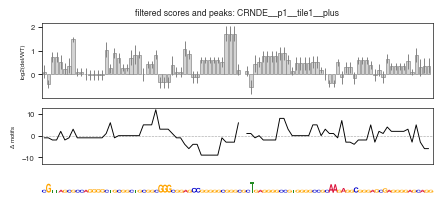

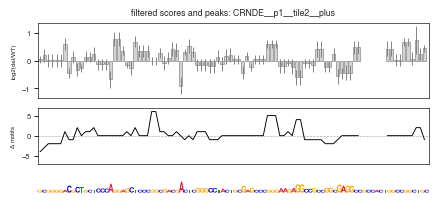

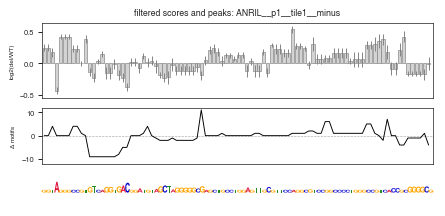

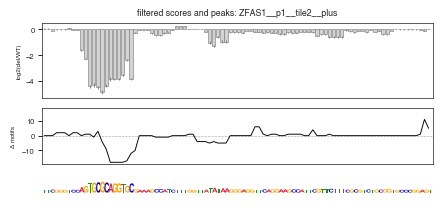

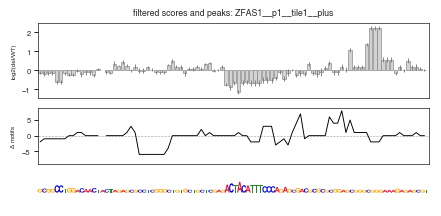

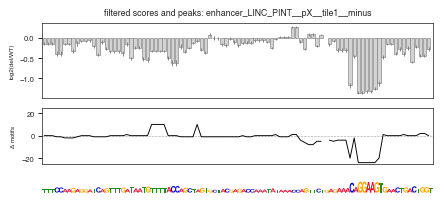

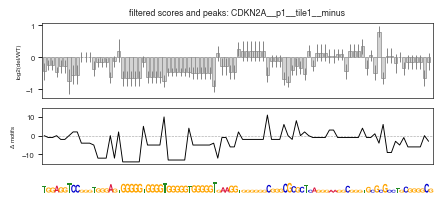

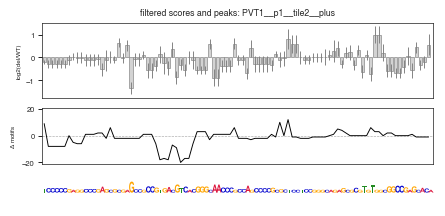

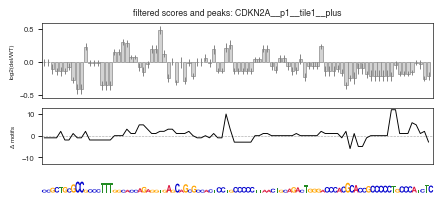

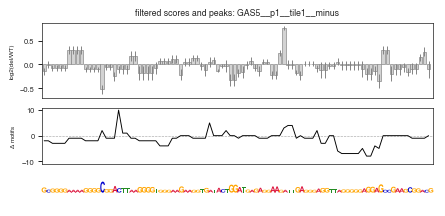

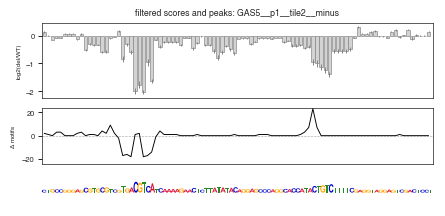

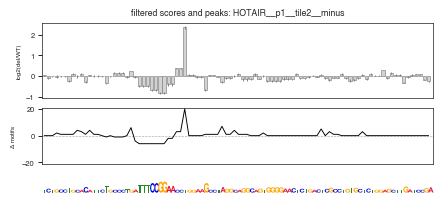

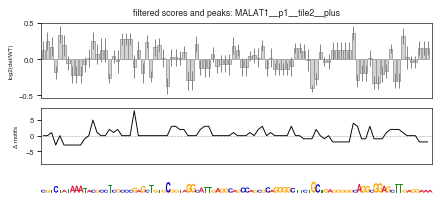

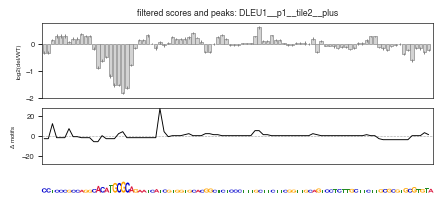

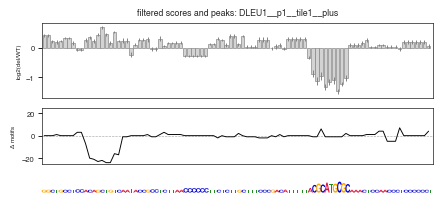

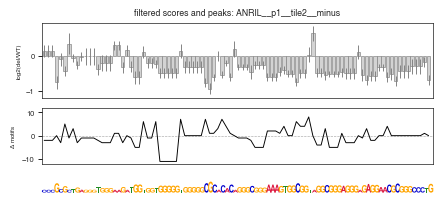

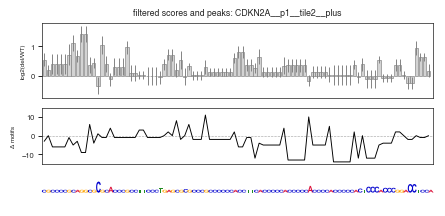

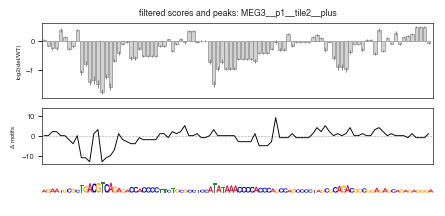

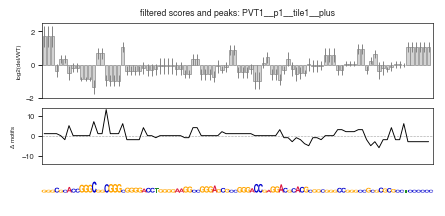

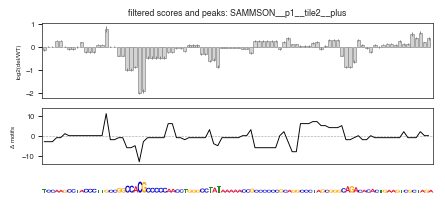

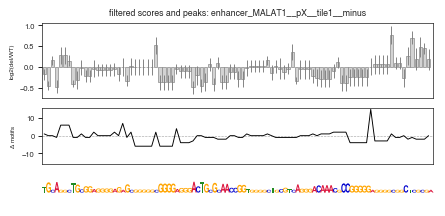

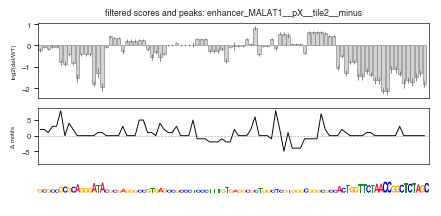

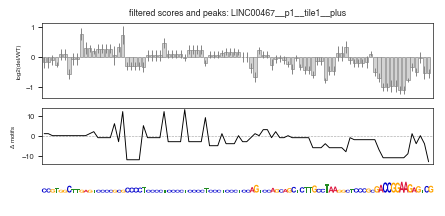

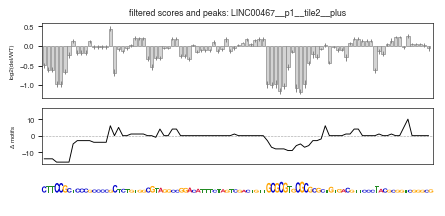

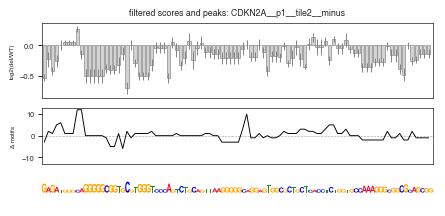

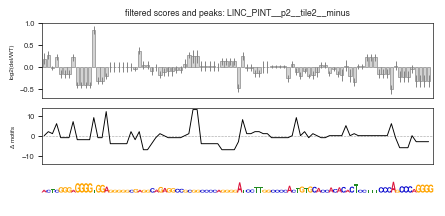

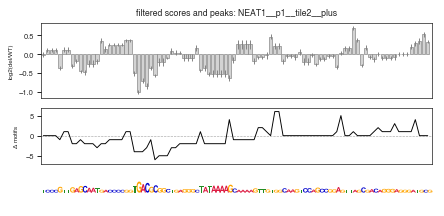

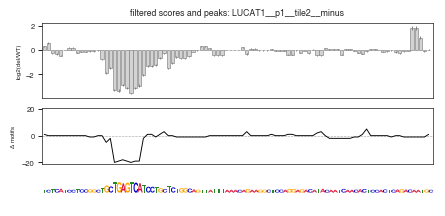

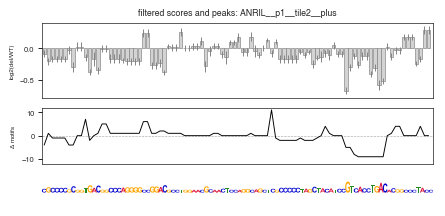

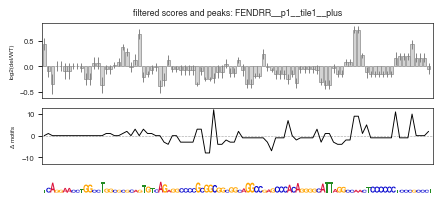

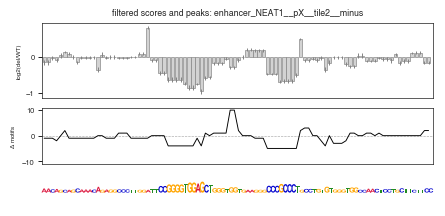

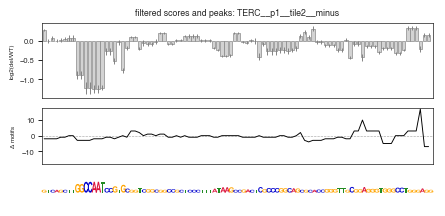

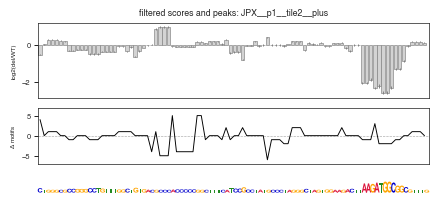

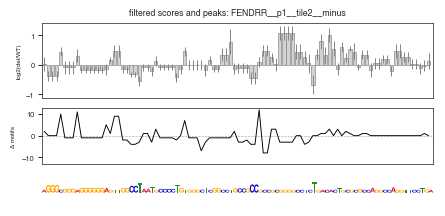

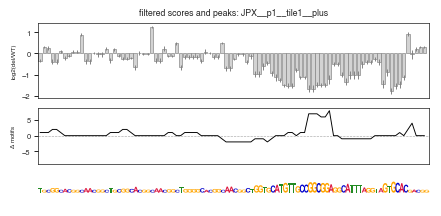

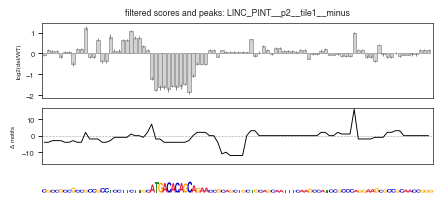

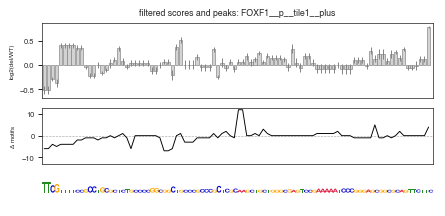

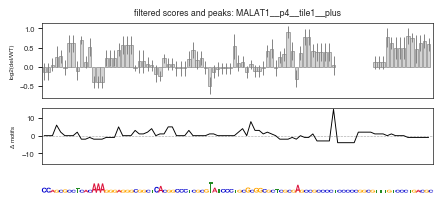

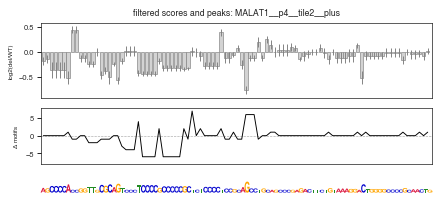

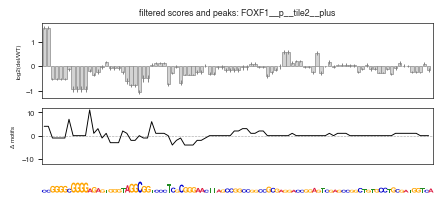

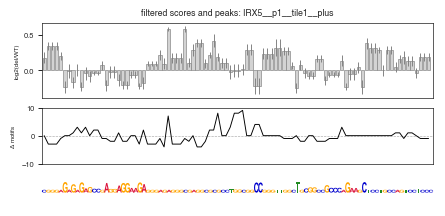

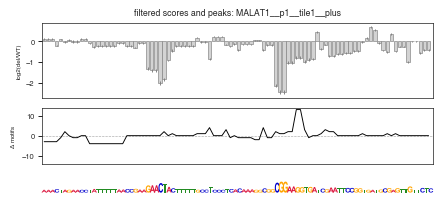

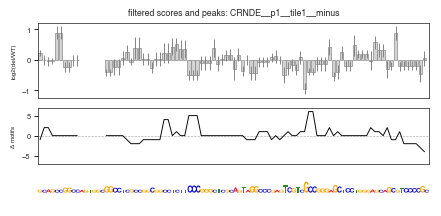

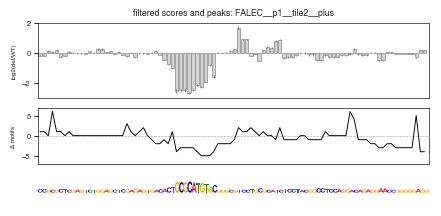

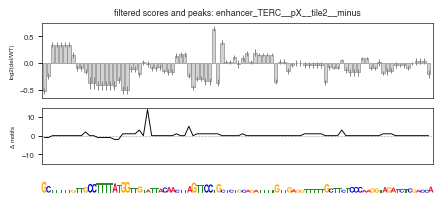

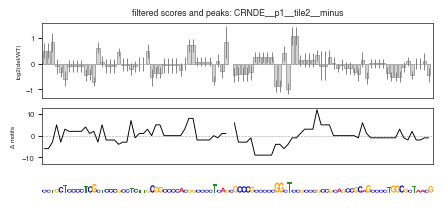

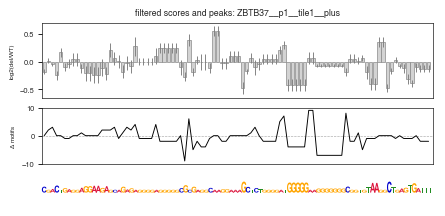

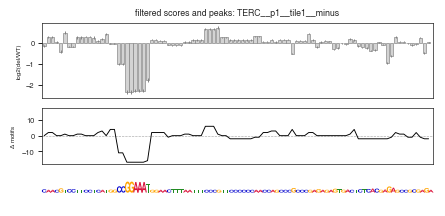

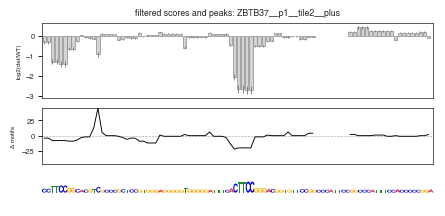

In [188]:
all_dels_tfs = pd.DataFrame()
for name in dels_fixed:
    
    df = dels_fixed[name].sort_values(by="delpos")
    seq = list(df["seq"])
    scores = list(df["mean.log2FC"])
    scaled_scores = list(df["loss_score_raw_scaled"])
    yerrs = list(df["se"])
    scores_filt = list(df["filtered_score"])
    
    # get wt motif # for reference
    del_id = df.del_id.iloc[0]
    wt_tfs = tfbs_wt[tfbs_wt["del_id"] == del_id]["n_tfs"].iloc[0]
    df["delta_tfs"] = df["n_tfs"] - wt_tfs
    motif_vals = list(df["delta_tfs"])
    all_dels_tfs = all_dels_tfs.append(df)
    
    # plot
    plot_peaks_and_motifs((5.6, 2.5), 94, name, scores, yerrs, scaled_scores, 
                          motif_vals, seq, figs_dir)

## 5. plot correlation b/w all dels & all tfs

In [118]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [119]:
figs_dir = "figs/1__scatter/"
!mkdir -p $figs_dir

In [120]:
all_dels_tfs.head()

,delpos,mean.log2FC,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,...,loss_score_raw,loss_score_raw_scaled,filtered_score,sd,peak,del_id,unique_id,dupe_info,n_tfs,delta_tfs
0,11,0.117110,0.287587,C,1.0,not sig,-0.045059,0.982501,sig active,chr16,...,0.000000,0.000000,NaN,1.113818,no peak,CRNDE__p1__tile1__plus,FLIPPED_DELETION__Lincrna.flip.antisense__p1@C...,31.1.0.0.11.1,33.0,-1.0
1,12,-0.398691,0.173290,G,1.0,not sig,-0.045059,0.982501,sig active,chr16,...,0.398691,0.398691,NaN,0.671148,no peak,CRNDE__p1__tile1__plus,FLIPPED_DELETION__Lincrna.flip.antisense__p1@C...,31.1.0.0.12.1,33.0,-1.0
2,13,0.728174,0.217949,T,1.0,not sig,-0.045059,0.982501,sig active,chr16,...,0.000000,0.000000,0.079738,0.844113,no peak,CRNDE__p1__tile1__plus,FLIPPED_DELETION__Lincrna.flip.antisense__p1@C...,31.1.0.0.13.1,32.0,-2.0
3,14,0.728174,0.217949,T,1.0,not sig,-0.045059,0.982501,sig active,chr16,...,0.000000,0.000000,0.079738,0.844113,no peak,CRNDE__p1__tile1__plus,FLIPPED_DELETION__Lincrna.flip.antisense__p1@C...,31.1.0.0.14.1,32.0,-2.0
4,15,0.527508,0.281390,A,1.0,not sig,-0.045059,0.982501,sig active,chr16,...,0.000000,0.000000,0.000000,1.089819,no peak,CRNDE__p1__tile1__plus,FLIPPED_DELETION__Lincrna.flip.antisense__p1@C...,31.1.0.0.15.1,36.0,2.0


In [121]:
all_dels_tfs.del_id.unique()

array(['CRNDE__p1__tile1__plus', 'CRNDE__p1__tile2__plus',
       'ANRIL__p1__tile1__minus', 'ZFAS1__p1__tile2__plus',
       'ZFAS1__p1__tile1__plus', 'enhancer_LINC_PINT__pX__tile1__minus',
       'CDKN2A__p1__tile1__minus', 'PVT1__p1__tile2__plus',
       'CDKN2A__p1__tile1__plus', 'GAS5__p1__tile1__minus',
       'GAS5__p1__tile2__minus', 'HOTAIR__p1__tile2__minus',
       'MALAT1__p1__tile2__plus', 'DLEU1__p1__tile2__plus',
       'DLEU1__p1__tile1__plus', 'ANRIL__p1__tile2__minus',
       'CDKN2A__p1__tile2__plus', 'MEG3__p1__tile2__plus',
       'PVT1__p1__tile1__plus', 'SAMMSON__p1__tile2__plus',
       'enhancer_MALAT1__pX__tile1__minus',
       'enhancer_MALAT1__pX__tile2__minus', 'LINC00467__p1__tile1__plus',
       'LINC00467__p1__tile2__plus', 'CDKN2A__p1__tile2__minus',
       'LINC_PINT__p2__tile2__minus', 'NEAT1__p1__tile2__plus',
       'LUCAT1__p1__tile2__minus', 'ANRIL__p1__tile2__plus',
       'FENDRR__p1__tile1__plus', 'enhancer_NEAT1__pX__tile2__minus',
       'TE

In [122]:
all_dels_tfs[all_dels_tfs["del_id"].str.contains("HOTAIR")]

,delpos,mean.log2FC,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,...,loss_score_raw,loss_score_raw_scaled,filtered_score,sd,peak,del_id,unique_id,dupe_info,n_tfs,delta_tfs
0,11,0.030193,0.039927,T,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.000000,0.000000,NaN,0.154636,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.11.1,8.0,0.0
1,12,-0.113145,0.042893,C,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.113145,0.113145,NaN,0.166124,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.12.1,8.0,0.0
2,13,-0.021495,0.034560,T,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.021495,0.021495,0.036791,0.133852,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.13.1,8.0,0.0
3,14,-0.027546,0.062189,G,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.027546,0.027546,0.041145,0.240855,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.14.1,10.0,2.0
4,15,-0.021768,0.011813,C,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.021768,0.021768,0.065522,0.045751,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.15.1,9.0,1.0
5,16,-0.021768,0.011813,C,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.021768,0.021768,0.061223,0.045751,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.16.1,9.0,1.0
6,17,-0.235033,0.057249,T,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.235033,0.235033,0.056155,0.221723,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.17.1,9.0,1.0
7,18,0.103001,0.040105,G,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.000000,0.000000,0.051802,0.155326,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.18.1,9.0,1.0
8,19,-0.002208,0.070182,C,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.002208,0.002208,0.102081,0.271812,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.19.1,12.0,4.0
9,20,0.115041,0.053473,A,1.000000e+00,not sig,0.24595,1.27351,sig active,chr12,...,0.000000,0.000000,0.055075,0.207101,no peak,HOTAIR__p1__tile2__minus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,15.2.0.0.20.1,11.0,3.0


In [101]:
all_dels_tfs["delta_tfs_abs"] = np.abs(all_dels_tfs["delta_tfs"])
all_dels_tfs["del_abs"] = np.abs(all_dels_tfs["mean.log2FC"])
all_dels_tfs["delta_tfs_log"] = np.log(all_dels_tfs["delta_tfs"]+1)
no_nans = all_dels_tfs[~pd.isnull(all_dels_tfs["mean.log2FC"])]
sig_only = all_dels_tfs[all_dels_tfs["sig"] == "sig"]
len(sig_only)

216

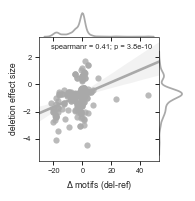

In [102]:
g = sns.jointplot(data=sig_only, x="delta_tfs", y="mean.log2FC", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})
g.set_axis_labels(r"$\Delta$ motifs (del-ref)", "deletion effect size")

plt.savefig("%s/%s_del_vs_tf_scatter.pdf" % (figs_dir, cell_type), dpi="figure", bbox_inches="tight")

## 6. re-correlate coverage metrics from deletions

In [103]:
hepg2_activ = pd.read_table(hepg2_activ_f, sep="\t")
k562_activ = pd.read_table(k562_activ_f, sep="\t")
hela_activ = pd.read_table(hela_activ_f, sep="\t")
hepg2_activ.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183


In [104]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna_" in x]
hela_reps = [x for x in hela_activ.columns if "rna_" in x]
k562_reps = [x for x in k562_activ.columns if "rna_" in x]
k562_reps

['rna_1', 'rna_2', 'rna_3', 'rna_4']

In [105]:
hepg2_activ["overall_mean"] = hepg2_activ[hepg2_reps].mean(axis=1)
hela_activ["overall_mean"] = hela_activ[hela_reps].mean(axis=1)
k562_activ["overall_mean"] = k562_activ[k562_reps].mean(axis=1)

In [106]:
mean_activ = hepg2_activ[["unique_id", "overall_mean"]].merge(hela_activ[["unique_id", "overall_mean"]], on="unique_id").merge(k562_activ[["unique_id", "overall_mean"]], on="unique_id")
mean_activ.columns = ["unique_id", "hepg2_mean", "hela_mean", "k562_mean"]
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,-1.450554,-1.292446,-2.027490
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,-0.635285,-1.418538,-1.797766
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,-1.210091,-0.771017,-1.539198
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,0.596985,-0.967580,-0.493138
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,-1.464824,-0.995570,-2.209022


In [107]:
mean_activ["tile_mean_expr"] = mean_activ[["hepg2_mean", "hela_mean", "k562_mean"]].mean(axis=1)
mean_activ["tile_mean_no_hela"] = mean_activ[["hepg2_mean", "k562_mean"]].mean(axis=1)
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,-1.450554,-1.292446,-2.027490,-1.590163,-1.739022
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,-0.635285,-1.418538,-1.797766,-1.283863,-1.216526
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,-1.210091,-0.771017,-1.539198,-1.173435,-1.374644
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,0.596985,-0.967580,-0.493138,-0.287911,0.051924
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,-1.464824,-0.995570,-2.209022,-1.556472,-1.836923


In [108]:
# first scale ranges to be positive
mean_activ["hepg2_scaled"] = scale_range(mean_activ["hepg2_mean"], 0, 100)
mean_activ["hela_scaled"] = scale_range(mean_activ["hela_mean"], 0, 100)
mean_activ["k562_scaled"] = scale_range(mean_activ["k562_mean"], 0, 100)

In [109]:
specificities = calculate_tissue_specificity(mean_activ[["hepg2_scaled", "hela_scaled", "k562_scaled"]])
mean_activ["tile_tissue_sp"] = specificities

specificities = calculate_tissue_specificity(mean_activ[["hepg2_scaled", "k562_scaled"]])
mean_activ["tile_tissue_sp_no_hela"] = specificities
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,tile_tissue_sp_no_hela
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,-1.450554,-1.292446,-2.027490,-1.590163,-1.739022,28.060420,52.795539,38.576558,0.245943,0.136302
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,-0.635285,-1.418538,-1.797766,-1.283863,-1.216526,37.072414,51.784414,40.367333,0.168191,0.040812
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,-1.210091,-0.771017,-1.539198,-1.173435,-1.374644,30.718501,56.976859,42.382966,0.238999,0.137608
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,0.596985,-0.967580,-0.493138,-0.287911,0.051924,50.693957,55.400631,50.537370,0.057580,0.001544
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,-1.464824,-0.995570,-2.209022,-1.556472,-1.836923,27.902677,55.176179,37.161454,0.273598,0.124575


In [110]:
mean_activ_wt = mean_activ[(mean_activ["unique_id"].str.contains("WILDTYPE")) |
                           (mean_activ["unique_id"].str.contains("FLIPPED"))]
mean_activ_wt = mean_activ_wt[(~mean_activ_wt["unique_id"].str.contains("DELETION")) &
                              (~mean_activ_wt["unique_id"].str.contains("SNP_INDIV"))]
mean_activ_wt["del_id"] = mean_activ_wt.apply(fix_names, name_dict=name_dict, loc_dict=loc_dict, axis=1)
mean_activ_wt.sample(5)

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,tile_tissue_sp_no_hela,del_id
3461719,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@IRX5_...,-0.995956,-0.795198,-1.565127,-1.118760,-1.280541,33.085555,56.782949,42.180837,0.224830,0.107813,IRX5__p1__tile2__plus
523,FLIPPED__mrna.flip.antisense__p1@CDKN2A__chr9:...,-0.107400,-0.074623,1.085711,0.301229,0.489155,42.907665,62.561216,62.845048,0.107254,0.158623,CDKN2A__p1__tile2__plus
3461690,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr2...,-1.170369,-0.964049,-1.616729,-1.250382,-1.393549,31.157581,55.428945,41.778582,0.228050,0.127111,enhancer_ZFAS1__pX__tile2__minus
3462228,WILDTYPE__Lincrna.flip.sense__p1@CRNDE__chr16:...,0.512738,-0.881353,1.458490,0.363292,0.985614,49.762687,56.092078,65.750996,0.130022,0.121582,CRNDE__p1__tile2__minus
3461694,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__p1@C...,0.018798,-0.986867,0.487597,-0.160157,0.253198,44.302670,55.245967,58.182546,0.096343,0.119279,CRNDE__p1__tile1__minus


In [111]:
len(mean_activ_wt)

62

In [112]:
mean_activ_wt = mean_activ_wt.merge(cov, on="del_id")
mean_activ_wt.sample(5)

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,tile_tissue_sp_no_hela,del_id,n_bp_covered,max_coverage,avg_tf_tissue_sp
18,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.130780,0.099493,ZBTB37__p1__tile2__plus,34,44,0.364099
1,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,2.730831,-0.048597,1.251017,1.311083,1.990924,74.281535,62.769914,64.133673,0.097195,0.068307,MEG3__p1__tile2__plus,56,13,0.536963
9,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@EN...,2.235864,-0.211535,1.505228,1.176519,1.870546,68.810167,61.463327,66.115334,0.048644,0.019582,SAMMSON__p1__tile2__plus,20,44,0.426563
11,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@JP...,0.842822,0.297225,0.685686,0.608578,0.764254,53.411445,65.543052,59.726719,0.091278,0.052868,JPX__p1__tile1__plus,32,0,NaN
20,WILDTYPE__Antisense.noflip.NA__p2@FLJ43663__ch...,1.416947,0.185687,1.088476,0.897037,1.252712,59.757838,64.648635,62.866607,0.034406,0.024725,LINC_PINT__p2__tile1__minus,36,18,0.404054


In [113]:
len(mean_activ_wt)

21

In [114]:
mean_activ_wt["log_bp_covered"] = np.log(mean_activ_wt["n_bp_covered"]+1)
mean_activ_wt["log_max_coverage"] = np.log(mean_activ_wt["max_coverage"]+1)
mean_activ_wt["log_avg_tf_tissue_sp"] = np.log(mean_activ_wt["avg_tf_tissue_sp"]+1)

In [115]:
mean_activ_wt.sort_values(by="max_coverage", ascending=False).head(10)

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,tile_tissue_sp_no_hela,del_id,n_bp_covered,max_coverage,avg_tf_tissue_sp,log_bp_covered,log_max_coverage,log_avg_tf_tissue_sp
9,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@EN...,2.235864,-0.211535,1.505228,1.176519,1.870546,68.810167,61.463327,66.115334,0.048644,0.019582,SAMMSON__p1__tile2__plus,20,44,0.426563,3.044522,3.806662,0.355268
18,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.130780,0.099493,ZBTB37__p1__tile2__plus,34,44,0.364099,3.555348,3.806662,0.310494
16,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@TE...,1.980673,-0.054253,0.650204,0.858875,1.315439,65.989279,62.724561,59.450123,0.049523,0.049547,TERC__p1__tile1__minus,15,34,0.430477,2.772589,3.555348,0.358008
0,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.739875,0.924601,3.471690,3.045389,4.105782,96.489558,70.573956,81.444595,0.141503,0.077962,GAS5__p1__tile2__minus,65,27,0.504673,4.189655,3.332205,0.408576
20,WILDTYPE__Antisense.noflip.NA__p2@FLJ43663__ch...,1.416947,0.185687,1.088476,0.897037,1.252712,59.757838,64.648635,62.866607,0.034406,0.024725,LINC_PINT__p2__tile1__minus,36,18,0.404054,3.610918,2.944439,0.339364
10,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@EN...,2.044930,0.162261,0.474924,0.894038,1.259927,66.699569,64.460783,58.083753,0.054246,0.064587,LUCAT1__p1__tile2__minus,20,17,0.443211,3.044522,2.890372,0.366870
3,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.731591,0.588306,2.830915,2.716937,3.781253,96.397983,67.877221,76.449531,0.167601,0.103469,ZFAS1__p1__tile2__plus,51,15,0.479439,3.951244,2.772589,0.391663
1,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,2.730831,-0.048597,1.251017,1.311083,1.990924,74.281535,62.769914,64.133673,0.097195,0.068307,MEG3__p1__tile2__plus,56,13,0.536963,4.043051,2.639057,0.429809
19,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p@chr16:...,0.504326,-0.091104,-0.076002,0.112406,0.214162,49.669700,62.429053,53.789089,0.114259,0.038292,FOXF1__p__tile2__plus,23,10,0.328841,3.178054,2.397895,0.284307
8,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@EN...,1.763648,-0.407179,0.349396,0.568622,1.056522,63.590279,59.894465,57.105217,0.053367,0.050991,FALEC__p1__tile2__plus,22,9,0.262808,3.135494,2.302585,0.233338


In [116]:
if cell_type == "HepG2":
    mean_col = "hepg2_mean"
elif cell_type == "K562":
    mean_col = "k562_mean"

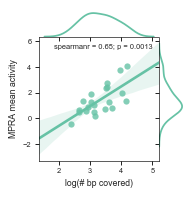

In [117]:
g = sns.jointplot(data=mean_activ_wt, x="log_bp_covered", y="tile_mean_no_hela", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color=sns.color_palette("Set2")[0], scatter_kws={"s": 25})
g.set_axis_labels("log(# bp covered)", "MPRA mean activity")


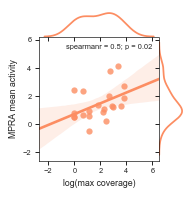

In [118]:
g = sns.jointplot(data=mean_activ_wt, x="log_max_coverage", y="tile_mean_no_hela", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color=sns.color_palette("Set2")[1], scatter_kws={"s": 25})
g.set_axis_labels("log(max coverage)", "MPRA mean activity")

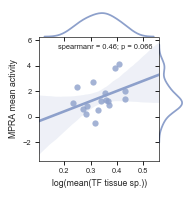

In [119]:
g = sns.jointplot(data=mean_activ_wt, x="log_avg_tf_tissue_sp", y="tile_mean_no_hela", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color=sns.color_palette("Set2")[2], scatter_kws={"s": 25})
g.set_axis_labels("log(mean(TF tissue sp.))", "MPRA mean activity")

## 7. correlate motifs & motif # with cluster size per tile

In [120]:
mean_activ_wt_fimo = mean_activ_wt.merge(fimo, on="unique_id")
mean_activ_wt_fimo = mean_activ_wt_fimo.merge(clusters, on="motif")
mean_activ_wt_fimo.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,...,motif,start,stop,strand,score,pval,qval,seq,cluster_num,cluster_count
0,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.739875,0.924601,3.471690,3.045389,4.105782,96.489558,70.573956,81.444595,0.141503,...,JDP2(var.2),28,39,-,19.1429,2.510000e-07,0.00297,GATGACGTCACG,108,1
1,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.739875,0.924601,3.471690,3.045389,4.105782,96.489558,70.573956,81.444595,0.141503,...,JDP2(var.2),28,39,+,15.5918,2.760000e-06,0.01610,CGTGACGTCATC,108,1
2,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,2.730831,-0.048597,1.251017,1.311083,1.990924,74.281535,62.769914,64.133673,0.097195,...,JDP2(var.2),18,29,+,11.1633,1.710000e-05,0.03920,GCTGACGTCAGA,108,1
3,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,2.730831,-0.048597,1.251017,1.311083,1.990924,74.281535,62.769914,64.133673,0.097195,...,JDP2(var.2),18,29,-,11.0408,1.830000e-05,0.03920,TCTGACGTCAGC,108,1
4,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.739875,0.924601,3.471690,3.045389,4.105782,96.489558,70.573956,81.444595,0.141503,...,BATF3,27,40,-,16.2273,5.590000e-07,0.00348,TGATGACGTCACGA,158,1


In [121]:
mean_activ_wt_fimo_deduped = mean_activ_wt_fimo.drop_duplicates(subset=["unique_id", "motif"])
mean_activ_wt_fimo_sig = mean_activ_wt_fimo_deduped[mean_activ_wt_fimo_deduped["qval"] < 0.05]
mean_activ_wt_fimo_sig.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,...,motif,start,stop,strand,score,pval,qval,seq,cluster_num,cluster_count
0,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.739875,0.924601,3.471690,3.045389,4.105782,96.489558,70.573956,81.444595,0.141503,...,JDP2(var.2),28,39,-,19.14290,2.510000e-07,0.00297,GATGACGTCACG,108,1
2,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,2.730831,-0.048597,1.251017,1.311083,1.990924,74.281535,62.769914,64.133673,0.097195,...,JDP2(var.2),18,29,+,11.16330,1.710000e-05,0.03920,GCTGACGTCAGA,108,1
4,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.739875,0.924601,3.471690,3.045389,4.105782,96.489558,70.573956,81.444595,0.141503,...,BATF3,27,40,-,16.22730,5.590000e-07,0.00348,TGATGACGTCACGA,158,1
6,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,2.730831,-0.048597,1.251017,1.311083,1.990924,74.281535,62.769914,64.133673,0.097195,...,BATF3,17,30,+,8.51515,8.490000e-06,0.03220,CGCTGACGTCAGAG,158,1
8,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,4.739875,0.924601,3.471690,3.045389,4.105782,96.489558,70.573956,81.444595,0.141503,...,HINFP,2,13,-,16.66670,1.110000e-06,0.00437,CAGCGTCCGCTT,136,1


In [122]:
clus_size = mean_activ_wt_fimo_sig.groupby("del_id")["cluster_count"].agg("mean").reset_index()
motif_count = mean_activ_wt_fimo.groupby("del_id")["motif"].agg("count").reset_index()
expr = mean_activ_wt_fimo_sig.groupby("del_id")["tile_mean_no_hela"].agg("mean").reset_index()
wt_fimo_grp = clus_size.merge(motif_count, on="del_id").merge(expr, on="del_id")
wt_fimo_grp.columns = ["del_id", "avg_cluster_size", "motif_count", "mean_activ"]
wt_fimo_grp

,del_id,avg_cluster_size,motif_count,mean_activ
0,DLEU1__p1__tile1__plus,4.500000,46,0.568297
1,DLEU1__p1__tile2__plus,2.800000,20,0.836739
2,FALEC__p1__tile2__plus,2.571429,17,1.056522
3,FOXF1__p__tile2__plus,2.900000,13,0.214162
4,GAS5__p1__tile2__minus,5.000000,21,4.105782
5,JPX__p1__tile2__plus,3.090909,21,0.911338
6,LINC00467__p1__tile1__plus,3.117647,86,1.354379
7,LINC00467__p1__tile2__plus,2.777778,34,2.329529
8,LINC_PINT__p2__tile1__minus,5.250000,31,1.252712
9,LUCAT1__p1__tile2__minus,8.000000,24,1.259927


In [123]:
mean_activ_wt_fimo_deduped[mean_activ_wt_fimo_deduped["del_id"] == "ZBTB37__p1__tile2__plus"]

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,tile_mean_no_hela,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,...,motif,start,stop,strand,score,pval,qval,seq,cluster_num,cluster_count
46,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,Klf4,41,50,+,12.70410,2.120000e-05,0.01300,GGGGTGGGGG,143,5
54,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,RREB1,35,54,-,9.34862,1.100000e-05,0.00550,AAATCCCCCACCCCCTCCCA,65,23
67,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,KLF5,41,50,-,14.77550,6.590000e-06,0.00536,CCCCCACCCC,142,4
108,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,ZIC3,29,43,-,10.88570,2.210000e-05,0.05850,CCCCTCCCACGGAGC,141,1
126,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,SP3,40,50,-,14.36590,5.370000e-06,0.00701,CCCCCACCCCC,132,4
216,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,EGR1,37,50,-,19.92310,4.200000e-08,0.00022,CCCCCACCCCCTCC,143,5
240,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,SP1,40,50,-,15.84620,2.480000e-06,0.00220,CCCCCACCCCC,142,4
265,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,SP2,36,50,-,17.37930,6.480000e-07,0.00117,CCCCCACCCCCTCCC,144,1
297,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,KLF16,40,50,-,14.67240,6.270000e-06,0.00572,CCCCCACCCCC,143,5
304,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,3.719645,0.695398,1.779822,2.064955,2.749733,85.211916,68.735983,68.255887,0.13078,...,EGR2,31,41,-,9.05172,8.290000e-05,0.07060,CCTCCCACGGA,146,1


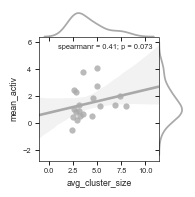

In [124]:
g = sns.jointplot(data=wt_fimo_grp, x="avg_cluster_size", y="mean_activ", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})

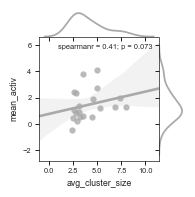

In [125]:
g = sns.jointplot(data=wt_fimo_grp, x="avg_cluster_size", y="mean_activ", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})